# Setup COCO API


In [ ]:
!pip install Cython
!pip install -q "tqdm>=4.36.1"

In [ ]:
!git clone https://github.com/waleedka/coco
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

In [7]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip ./annotations_trainval2017.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Import needed and Load COCO categories

In [1]:
from pycocotools.coco import COCO
from sklearn import tree, metrics
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop
from skimage import io, color
from math import floor, ceil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# import graphviz 

In [3]:
!where python

D:\anaconda\envs\compvis\python.exe
C:\Python38\python.exe
D:\anaconda\python.exe
C:\Users\glaci\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
from tqdm import tqdm

# # quietly deep-reload tqdm
# import sys
# from IPython.lib import deepreload 

# stdout = sys.stdout
# sys.stdout = open('junk','w')
# deepreload.reload(tqdm)
# sys.stdout = stdout

In [5]:
%%capture
from tqdm.notebook import tqdm

NotImplementedError: 

In [4]:
def split_integer(num):
  return (floor(num/2), ceil(num/2))

In [ ]:
from sklearn.datasets import load_iris
X_i, y = load_iris(return_X_y=True)
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X, y)
# tree.plot_tree(clf) 
print(X_i.shape, y.shape)

(150, 4) (150,)


In [3]:
train_instance="annotations/instances_train2017.json"
val_instance="annotations/instances_val2017.json"


In [4]:
coco = COCO(train_instance)
catIds = coco.getCatIds(catNms=['dog','cat'])
img_catdog = coco.getImgIds(catIds=catIds)
img_dog = list(set(coco.getImgIds(catIds=coco.getCatIds(catNms=['dog']))) - set(img_catdog))
img_cat = list(set(coco.getImgIds(catIds=coco.getCatIds(catNms=['cat']))) - set(img_catdog))
print("Dog Image Total: ",len(img_dog),"\nCat Image Total: ", len(img_cat))

loading annotations into memory...
Done (t=18.94s)
creating index...
index created!
Dog Image Total:  4177 
Cat Image Total:  3906


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms=set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
sports electronic animal furniture person accessory outdoor appliance kitchen vehicle indoor food



In [6]:
def create_dataset_id(coco):
  catIds = coco.getCatIds(catNms=['dog','cat'])
  img_catdog = coco.getImgIds(catIds=catIds)
  img_dog = list(set(coco.getImgIds(catIds=coco.getCatIds(catNms=['dog']))) - set(img_catdog))
  img_cat = list(set(coco.getImgIds(catIds=coco.getCatIds(catNms=['cat']))) - set(img_catdog))
  print("Dog Image Total: ",len(img_dog),"\nCat Image Total: ", len(img_cat))
  return img_dog + img_cat, np.array(len(img_dog) * [1] + len(img_cat) * [0])

In [8]:
coco_val = COCO(val_instance)
X_val, y_val = create_dataset_id(coco_val)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Dog Image Total:  165 
Cat Image Total:  172


In [9]:
def resize_crop_img(coco_img, target_width=150):
  I = io.imread(coco_img['coco_url'])
  factor = target_width/min(I.shape[0:2])
  resize_target = (round(I.shape[0] * factor), round(I.shape[1] * factor))
  resized_image = (resize(I, resize_target, anti_aliasing=False) * 255).astype(np.uint8)
  crop_width = (split_integer(resize_target[0] - target_width), split_integer(resize_target[1] - target_width), (0,0))
  cropped_image = crop(color.gray2rgb(resized_image), crop_width)
  return cropped_image

def flatten_img(img):
  return img.flatten()

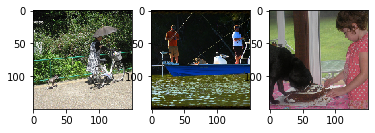

In [10]:
# img = coco.loadImgs(img_dog[np.random.randint(0,len(img_dog))])[0]
# I = io.imread(img['coco_url'])
# target_width = 150
# factor = target_width/min(I.shape[0:2])
# resize_target = (int(I.shape[0] * factor), int(I.shape[1] * factor))
# resized_image = (resize(I, resize_target, anti_aliasing=False) * 255).astype(np.uint8)
# crop_width = (split_integer(resize_target[0] - target_width), split_integer(resize_target[1] - target_width), (0,0))
# cropped_image = crop(resized_image, crop_width)
for i in range(1,4):
  img = coco.loadImgs(img_dog[np.random.randint(0,len(img_dog))])[0]
  plt.subplot(1,3,i)
  plt.imshow(resize_crop_img(img))
# plt.subplot(1,3,1)
# plt.imshow(I)
# plt.subplot(1,3,2)
# plt.imshow(resized_image)
# plt.subplot(1,3,3)
# plt.imshow(resize_crop_img(img))



*   Gabungin Data training dan validasi,
*   Cari tau kalau di DTL, Random Forest sama XGBoost ada train/val/test ga?
- Apakah urutan pengaruh untuk hasil?
- Bikin fungsi buat evaluate hasilnya ke set tertentu. Coba cari tau evaluation metrics apa yang relevan buat ini  di SKLearn



In [11]:
X_train, y = img_dog + img_cat, np.array(len(img_dog) * [1] + len(img_cat) * [0])

In [16]:
X_train_images = []
for ids in X_train:
    

(4177,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y)
pca = PCA(n_components = 24)
pca.fit(X_train)
reduced_X_train, reduced_X_test = pca.transform(X_train), pca.transform(X_test)

# best_model = best_SVC(reduced_X_train,y_train)
# predictions = best_model.predict(reduced_X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[488206. 505645. 346266. ... 455123.  13529. 312056.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [23]:
X_error = [525513, 1589, 184224, 430417, 447520, 579239, 154053, 286327, 221840, 287422, 75052, 371046, 518951, 290422, 77709, 373193, 62347, 111583, 341892, 342921, 313665, 118929, 168356, 103447, 38474, 301014, 438802, 95753, 178378, 32405]
X_loaded = []
for x in tqdm(X_train):
  try: 
    cropped = resize_crop_img(coco.loadImgs(x)[0]).flatten()
    X_loaded += [cropped]
  except :
    print(x)
print("Finished with length: ",len(X_loaded))
X_loaded = np.array(X_loaded)
print("Converted to ndarray with shape: ",X_loaded.shape, y.shape)
# X_loaded = [ resize_crop_img(coco.loadImgs(x)[0]).flatten() for x in X_error]
# X_loaded.shape

  2%|▏         | 110/6062 [02:50<2:30:27,  1.52s/it]

In [ ]:
img = coco.loadImgs(1589)[0]
I = io.imread(img['coco_url'])
target_width = 150
factor = target_width/min(I.shape[0:2])
resize_target = (round(I.shape[0] * factor), round(I.shape[1] * factor))
resized_image = (resize(I, resize_target, anti_aliasing=False) * 255).astype(np.uint8)
crop_width = (split_integer(resize_target[0] - target_width), split_integer(resize_target[1] - target_width), (0,0))
cropped_image = crop(color.gray2rgb(resized_image), crop_width) 

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_loaded, y)
# tree.plot_tree(clf) 

In [ ]:
y_pred = []
for x in tqdm(X_val):
  try : 
    cropped = resize_crop_img(coco_val.loadImgs(x)[0]).flatten()
    y_pred += [clf.predict([cropped])[0]]
  except :
    print(x)
y_pred = np.array(y_pred)
# print(clf.predict([resize_crop_img(coco.loadImgs(1589)[0]).flatten()]))

In [ ]:
print(metrics.classification_report(y_val, y_pred, target_names=['Dog','Cat']))

              precision    recall  f1-score   support

         Dog       0.57      0.58      0.58       172
         Cat       0.56      0.55      0.55       165

    accuracy                           0.56       337
   macro avg       0.56      0.56      0.56       337
weighted avg       0.56      0.56      0.56       337

